# 04 Build Models

## Imports

In [2]:
import pandas as pd
import numpy as np
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


# Functions

In [3]:
def get_metrics(y_true, y_predict, print_scores = True):
    matrix_def = [['tn','fp'], ['fn','tp']]
    matrix = confusion_matrix(y_true, y_predict)
    tn, fp, fn, tp = matrix.ravel()
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    misclass = 1-accuracy
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    if print_scores:
        print('Matrix Definition')
        print(np.array(matrix_def))
        print('')
        print('Confusion Matrix')
        print(matrix)
        print('')
        print('METRICS')
        print('accuracy:', accuracy)
        print('misclass:', misclass)
        print('sensitivity:', sensitivity)
        print('specificity:', specificity)
    else:
        return accuracy, misclass, sensitivity, specificity, precision

## Read in Train and Test Data

In [4]:
with open('../Cleansed_Data/X_train_ss.pkl','rb') as f:
    X_train_ss = pickle.load(f)
    
with open('../Cleansed_Data/X_test_ss.pkl','rb') as f:
    X_test_ss = pickle.load(f)
    
with open('../Cleansed_Data/y_train.pkl','rb') as f:
    y_train = pickle.load(f)
    
with open('../Cleansed_Data/y_test.pkl','rb') as f:
    y_test = pickle.load(f)

## Simple Logistic Regression

In [5]:
lr = LogisticRegression()
lr.fit(X_train_ss, y_train)
lr.score(X_train_ss, y_train), lr.score(X_test_ss, y_test)

get_metrics(lr.predict(X_test_ss), y_test)

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[2000  109]
 [   5    5]]

METRICS
accuracy: 0.9462010382255781
misclass: 0.053798961774421894
sensitivity: 0.5
specificity: 0.948316737790422


## Neural Net

In [6]:
# Check number of inputs
print(X_train_ss.shape[1])
layer1 = X_train_ss.shape[1]
layer2 = 15

166


In [7]:
model = Sequential()
model.add(Dense(layer1, activation='relu', input_dim=X_train_ss.shape[1])) #Makes this dynamic
model.add(Dropout(.4))
model.add(Dense(layer2, activation='relu')) #Makes this dynamic
model.add(Dense(1, activation='sigmoid'))

In [8]:
adam = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])  #mean_squared_error

In [9]:
history = model.fit(X_train_ss, y_train, validation_data=(X_test_ss, y_test), epochs=100, batch_size=32, verbose=0)

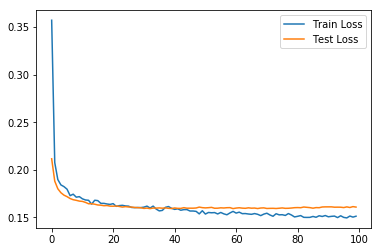

In [10]:
plt.plot(history.history['loss'], label= 'Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')

plt.legend()

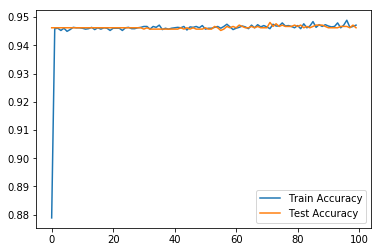

In [11]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.legend()

In [12]:
roc_auc_score(y_test, model.predict(X_test_ss))

0.8633678960493503

## Random Forest

In [13]:
rf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=3)

In [14]:
rf.fit(X_train_ss, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
rf.score(X_train_ss, y_train)

0.9501258653241033

In [16]:
rf.score(X_test_ss, y_test)

0.9462010382255781

In [17]:
y_test.mean()

0.053798961774421894

In [18]:
rf.predict(X_test_ss).mean()

0.0037753657385559227

In [19]:
roc_auc_score(y_test, rf.predict_proba(X_test_ss)[:,1])

0.8384411777573609

In [20]:
feat_imp = pd.DataFrame(rf.feature_importances_, index=X_test_ss.columns, columns=['Importance']).sort_values('Importance', ascending=False)

In [21]:
feat_imp.head(20)

,Importance
Longitude,0.325766
Latitude,0.296282
Species_CULEX PIPIENS/RESTUANS,0.027530
Species_CULEX PIPIENS,0.026275
Species_CULEX RESTUANS,0.019312
photoperiod,0.010352
photoperiod_2_back,0.009889
DewPointC_1_back,0.008773
photoperiod_3_back,0.007197
TminC_2_back,0.006845


In [35]:
with open('../Models/rf.pkl', 'wb') as f:
    pickle.dump(rf, f)

## Pull in Submission Data

In [22]:
X_submit = pd.read_csv('../Cleansed_Data/test_final.csv', index_col=0)

## Predict Using Random Forest

In [23]:
col_to_be_added = np.setdiff1d(X_train_ss.columns,X_submit.columns)
col_to_be_dropped = np.setdiff1d(X_submit.columns,X_train_ss.columns)

X_submit.drop(col_to_be_dropped,axis=1,inplace=True)
for col in col_to_be_added:
    X_submit[col] = 0

In [24]:
rf_predicts = rf.predict_proba(X_submit)

In [25]:
submission_df = pd.DataFrame([pred[1] for pred in rf_predicts], columns=['WnvPresent'],index=X_submit.index)
submission_df.to_csv('../Cleansed_Data/submission_rf.csv', )

In [26]:
indecies = submission_df[submission_df.WnvPresent > .1].index

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2edd44e0>]],
      dtype=object)

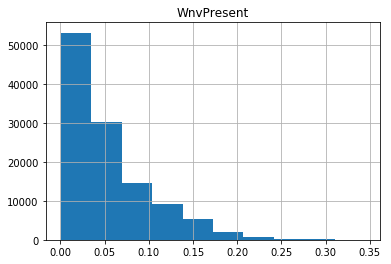

In [29]:
submission_df.hist()

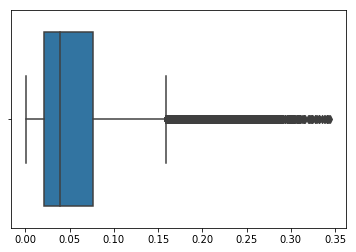

In [30]:
sns.boxplot(submission_df)

In [32]:
X_submit['predict'] = submission_df

In [34]:
X_submit[X_submit.predict > 0.2]

,Latitude,Longitude,BR,HZ,RA,TSRA,VCTS,FU,TS,DZ,...,Month_10,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Month_05,predict
Id,,,,,,,,,,,,,,,,,,,,,
17942,1.217867,-2.350545,-0.700859,-0.491283,-0.740166,-0.511184,-0.227185,0.0,-0.378881,-0.121847,...,-0.546994,-0.177892,0.0,1.855357,-0.898900,-0.633605,-0.115718,-0.037653,-0.166262,0.207197
17943,1.217867,-2.350545,-0.700859,-0.491283,-0.740166,-0.511184,-0.227185,0.0,-0.378881,-0.121847,...,-0.546994,-0.177892,0.0,-0.538980,1.112471,-0.633605,-0.115718,-0.037653,-0.166262,0.226405
17944,1.217867,-2.350545,-0.700859,-0.491283,-0.740166,-0.511184,-0.227185,0.0,-0.378881,-0.121847,...,-0.546994,-0.177892,1.0,-0.538980,-0.898900,-0.633605,-0.115718,-0.037653,-0.166262,0.201333
17946,1.217867,-2.350545,-0.700859,-0.491283,-0.740166,-0.511184,-0.227185,0.0,-0.378881,-0.121847,...,-0.546994,-0.177892,0.0,-0.538980,-0.898900,-0.633605,-0.115718,26.558112,-0.166262,0.201333
17947,1.217867,-2.350545,-0.700859,-0.491283,-0.740166,-0.511184,-0.227185,0.0,-0.378881,-0.121847,...,-0.546994,-0.177892,0.0,-0.538980,-0.898900,-0.633605,8.641676,-0.037653,-0.166262,0.201333
17948,1.217867,-2.350545,-0.700859,-0.491283,-0.740166,-0.511184,-0.227185,0.0,-0.378881,-0.121847,...,-0.546994,-0.177892,1.0,-0.538980,-0.898900,-0.633605,-0.115718,-0.037653,-0.166262,0.201333
17949,1.217867,-2.350545,-0.700859,-0.491283,-0.740166,-0.511184,-0.227185,0.0,-0.378881,-0.121847,...,-0.546994,5.621388,0.0,-0.538980,-0.898900,-0.633605,-0.115718,-0.037653,-0.166262,0.201333
17950,1.058923,-2.832142,-0.700859,-0.491283,-0.740166,-0.511184,-0.227185,0.0,-0.378881,-0.121847,...,-0.546994,-0.177892,0.0,1.855357,-0.898900,-0.633605,-0.115718,-0.037653,-0.166262,0.221127
17951,1.058923,-2.832142,-0.700859,-0.491283,-0.740166,-0.511184,-0.227185,0.0,-0.378881,-0.121847,...,-0.546994,-0.177892,0.0,-0.538980,1.112471,-0.633605,-0.115718,-0.037653,-0.166262,0.218119
